# FINAL PROJECT: Uber Pickup Forecasting, PCA + Clustering
### Karl Walter, UC Berkeley
### CE 263N
### December 2020

## Data Exploration

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd 
#from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib
from matplotlib import cm

In [2]:
DATA_FILE = 'input/uber-raw-data-janjune-15.csv'
uber_data = pd.read_csv(DATA_FILE)
uber_data.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [3]:
locations = uber_data['locationID'].unique()
print('There are', str(len(locations)), 'taxi zones')

There are 262 taxi zones


In [4]:
uber_data['Pickup_date'] = pd.to_datetime(uber_data['Pickup_date'], format="%Y-%m-%d %H:%M:%S")
uber_data['DayOfWeekNum'] = uber_data['Pickup_date'].dt.dayofweek
uber_data['DayOfWeek'] = uber_data['Pickup_date'].dt.day_name()
uber_data['day'] = uber_data['Pickup_date'].dt.day
uber_data['year']  = uber_data['Pickup_date'].dt.year
uber_data['month'] = uber_data['Pickup_date'].dt.month
uber_data['hour'] = uber_data['Pickup_date'].dt.hour

In [5]:
uber_data.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,DayOfWeekNum,DayOfWeek,day,year,month,hour
0,B02617,2015-05-17 09:47:00,B02617,141,6,Sunday,17,2015,5,9
1,B02617,2015-05-17 09:47:00,B02617,65,6,Sunday,17,2015,5,9
2,B02617,2015-05-17 09:47:00,B02617,100,6,Sunday,17,2015,5,9
3,B02617,2015-05-17 09:47:00,B02774,80,6,Sunday,17,2015,5,9
4,B02617,2015-05-17 09:47:00,B02617,90,6,Sunday,17,2015,5,9


In [6]:
from datetime import datetime

In [7]:
uber_data['date_w_hr'] = pd.to_datetime(uber_data[['year','day','month','hour']])
uber_data.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,DayOfWeekNum,DayOfWeek,day,year,month,hour,date_w_hr
0,B02617,2015-05-17 09:47:00,B02617,141,6,Sunday,17,2015,5,9,2015-05-17 09:00:00
1,B02617,2015-05-17 09:47:00,B02617,65,6,Sunday,17,2015,5,9,2015-05-17 09:00:00
2,B02617,2015-05-17 09:47:00,B02617,100,6,Sunday,17,2015,5,9,2015-05-17 09:00:00
3,B02617,2015-05-17 09:47:00,B02774,80,6,Sunday,17,2015,5,9,2015-05-17 09:00:00
4,B02617,2015-05-17 09:47:00,B02617,90,6,Sunday,17,2015,5,9,2015-05-17 09:00:00


In [8]:
print(len(uber_data.index), "Uber trips were taken in NYC in Jan-Jun 2015")

14270479 Uber trips were taken in NYC in Jan-Jun 2015


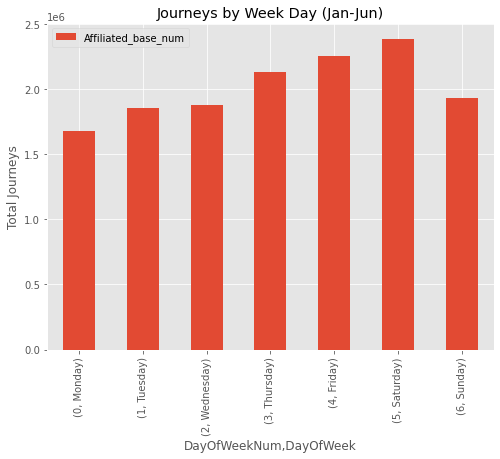

In [9]:
uber_weekdays = uber_data.pivot_table(index=['DayOfWeekNum','DayOfWeek'],
                                  values='Affiliated_base_num',
                                  aggfunc='count')
plt.style.use('ggplot')
uber_weekdays.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Journeys')
plt.title('Journeys by Week Day (Jan-Jun)');

In [10]:
uber_data_location_total = uber_data[['date_w_hr','locationID']].groupby(['locationID']).size().reset_index(name = 'total_trips')
#uber_data_locationSum = uber_data_locationSum.rename(columns={'Pickup_date':'total_trips'})
#uber_data_locationSum = uber_data_locationSum.sort_values(by=['total_trips'])
uber_data_location_total.sort_values(by='total_trips', ascending=False).head()

,locationID,total_trips
158,161,460732
227,231,420356
230,234,419045
78,79,407591
245,249,323989


Here we see the neighborhood-day pairs with the highest number of outgoing trips.

The top is June 27, 2015 to the East Village (a famous gay neighborhood in NYC). This was the day the Supreme Court legalized gay marriage!

In [11]:
uber_data_locationSum = uber_data[['locationID','year','month','day','date_w_hr']].groupby(['locationID', 'year','month','day','date_w_hr']).size().reset_index(name = 'trips')
uber_data_locationSum['date'] = pd.to_datetime(uber_data_locationSum[['year','month','day']])
#uber_data_locationSum = uber_data_locationSum.rename(columns={'Pickup_date':'total_trips'})
#uber_data_locationSum = uber_data_locationSum.sort_values(by=['total_trips'])
uber_data_locationSum.sort_values(by='trips', ascending=False).head()

,locationID,year,month,day,date_w_hr,trips,date
228261,79,2015,5,17,2015-05-17 00:00:00,609,2015-05-17
465091,161,2015,3,3,2015-03-03 20:00:00,581,2015-03-03
465092,161,2015,3,3,2015-03-03 21:00:00,570,2015-03-03
228259,79,2015,5,16,2015-05-16 22:00:00,564,2015-05-16
467130,161,2015,5,27,2015-05-27 20:00:00,554,2015-05-27


In [12]:
uber_data_locationSum.sort_values(by=['locationID', 'date_w_hr']).head()

,locationID,year,month,day,date_w_hr,trips,date
0,1,2015,1,1,2015-01-01 15:00:00,1,2015-01-01
1,1,2015,1,5,2015-01-05 06:00:00,1,2015-01-05
2,1,2015,1,8,2015-01-08 06:00:00,1,2015-01-08
3,1,2015,1,10,2015-01-10 08:00:00,1,2015-01-10
4,1,2015,1,12,2015-01-12 11:00:00,1,2015-01-12


## Feature Additions

**1. Starting Point - Make sure there are rows for every location-time combination**

In [13]:
uber_data_locationSum.head()

,locationID,year,month,day,date_w_hr,trips,date
0,1,2015,1,1,2015-01-01 15:00:00,1,2015-01-01
1,1,2015,1,5,2015-01-05 06:00:00,1,2015-01-05
2,1,2015,1,8,2015-01-08 06:00:00,1,2015-01-08
3,1,2015,1,10,2015-01-10 08:00:00,1,2015-01-10
4,1,2015,1,12,2015-01-12 11:00:00,1,2015-01-12


In [14]:
df_main = uber_data_locationSum.drop(columns=['date', 'month', 'day', 'year'])
df_main.head()

,locationID,date_w_hr,trips
0,1,2015-01-01 15:00:00,1
1,1,2015-01-05 06:00:00,1
2,1,2015-01-08 06:00:00,1
3,1,2015-01-10 08:00:00,1
4,1,2015-01-12 11:00:00,1


In [15]:
#https://stackoverflow.com/questions/31786881/adding-values-for-missing-data-combinations-in-pandas
from itertools import product
all_locationIDs = df_main['locationID'].unique()
all_date_w_hr = df_main['date_w_hr'].unique()
names = ["locationID", "date_w_hr"]
mind = pd.MultiIndex.from_product(
    [all_locationIDs, all_date_w_hr], names=names)
#list(product(all_locationIDs, all_date_w_hr))
df_main = df_main.set_index(names).reindex(mind, fill_value=0).reset_index()

In [16]:
df_main = df_main.sort_values(by=['locationID','date_w_hr'], ascending=True)
df_main.head()

,locationID,date_w_hr,trips
109,1,2015-01-01 00:00:00,0
110,1,2015-01-01 01:00:00,0
111,1,2015-01-01 02:00:00,0
112,1,2015-01-01 03:00:00,0
2298,1,2015-01-01 04:00:00,0


In [17]:
df_main['dayofweek'] = df_main['date_w_hr'].dt.dayofweek
df_main['day'] = df_main['date_w_hr'].dt.day
df_main['year']  = df_main['date_w_hr'].dt.year
df_main['month'] = df_main['date_w_hr'].dt.month
df_main['date'] = pd.to_datetime(df_main[['year','month','day']])
df_main['hour'] = df_main['date_w_hr'].dt.hour
df_main.head()

,locationID,date_w_hr,trips,dayofweek,day,year,month,date,hour
109,1,2015-01-01 00:00:00,0,3,1,2015,1,2015-01-01,0
110,1,2015-01-01 01:00:00,0,3,1,2015,1,2015-01-01,1
111,1,2015-01-01 02:00:00,0,3,1,2015,1,2015-01-01,2
112,1,2015-01-01 03:00:00,0,3,1,2015,1,2015-01-01,3
2298,1,2015-01-01 04:00:00,0,3,1,2015,1,2015-01-01,4


**2. Add weather data**

In [18]:
DATA_FILE = 'input/weather_data_jfk.csv'
weather_data = pd.read_csv(DATA_FILE)
weather_data.head()

,STATION,NAME,DATE,PRCP,TAVG
0,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",1/1/2015,0.00,33
1,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",1/2/2015,0.00,39
2,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",1/3/2015,0.94,36
3,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",1/4/2015,0.47,47
4,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",1/5/2015,0.00,43


In [19]:
weather_data['date'] = pd.to_datetime(weather_data['DATE'], format="%m/%d/%Y")
weather_data = weather_data.drop(columns=['DATE'])
weather_data.head()

,STATION,NAME,PRCP,TAVG,date
0,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,33,2015-01-01
1,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,39,2015-01-02
2,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.94,36,2015-01-03
3,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.47,47,2015-01-04
4,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",0.00,43,2015-01-05


In [20]:
len(weather_data.index)

181

In [21]:
df_main_2 = df_main.merge(weather_data, on=['date'], how='left')
if (len(df_main.index) == len(df_main_2.index)):
    print('Join success: did not add rows')
else:
    print('Join fail: rows added')

Join success: did not add rows


In [22]:
df_main_2 = df_main_2.drop(columns = ['STATION', 'NAME'])
df_main_2['dayofweek'] = df_main_2['date_w_hr'].dt.dayofweek
df_main_2.head()

,locationID,date_w_hr,trips,dayofweek,day,year,month,date,hour,PRCP,TAVG
0,1,2015-01-01 00:00:00,0,3,1,2015,1,2015-01-01,0,0.0,33
1,1,2015-01-01 01:00:00,0,3,1,2015,1,2015-01-01,1,0.0,33
2,1,2015-01-01 02:00:00,0,3,1,2015,1,2015-01-01,2,0.0,33
3,1,2015-01-01 03:00:00,0,3,1,2015,1,2015-01-01,3,0.0,33
4,1,2015-01-01 04:00:00,0,3,1,2015,1,2015-01-01,4,0.0,33


**3. Trips from last week**

In [23]:
from datetime import timedelta

In [24]:
df_last_week_join = df_main_2[['date_w_hr', 'locationID', 'trips']]
df_last_week_join['date_w_hr'] = df_last_week_join['date_w_hr'] + timedelta(days=7)
df_last_week_join['trips_last_wk'] = df_last_week_join['trips']
df_last_week_join = df_last_week_join.drop(columns='trips')
df_last_week_join.head()

C:\ProgramData\Anaconda3\envs\skmob\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\envs\skmob\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date_w_hr,locationID,trips_last_wk
0,2015-01-08 00:00:00,1,0
1,2015-01-08 01:00:00,1,0
2,2015-01-08 02:00:00,1,0
3,2015-01-08 03:00:00,1,0
4,2015-01-08 04:00:00,1,0


In [25]:
# UNUSED: COULD CONSIDER ADDING TRIPS FROM PRIOR HOUR AS FEATURE
df_last_hour_join = df_main[['date_w_hr', 'locationID', 'trips']]
df_last_hour_join['date_w_hr'] = df_last_hour_join['date_w_hr'] + timedelta(hours=1)
df_last_hour_join['trips_last_hr'] = df_last_hour_join['trips']
df_last_hour_join = df_last_hour_join.drop(columns='trips')
df_last_hour_join.head()

C:\ProgramData\Anaconda3\envs\skmob\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\skmob\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,date_w_hr,locationID,trips_last_hr
109,2015-01-01 01:00:00,1,0
110,2015-01-01 02:00:00,1,0
111,2015-01-01 03:00:00,1,0
112,2015-01-01 04:00:00,1,0
2298,2015-01-01 05:00:00,1,0


In [26]:
df_main_3 = df_main_2.merge(df_last_week_join, on=['date_w_hr','locationID'], how='left')

In [27]:
df_main_3.head()

,locationID,date_w_hr,trips,dayofweek,day,year,month,date,hour,PRCP,TAVG,trips_last_wk
0,1,2015-01-01 00:00:00,0,3,1,2015,1,2015-01-01,0,0.0,33,NaN
1,1,2015-01-01 01:00:00,0,3,1,2015,1,2015-01-01,1,0.0,33,NaN
2,1,2015-01-01 02:00:00,0,3,1,2015,1,2015-01-01,2,0.0,33,NaN
3,1,2015-01-01 03:00:00,0,3,1,2015,1,2015-01-01,3,0.0,33,NaN
4,1,2015-01-01 04:00:00,0,3,1,2015,1,2015-01-01,4,0.0,33,NaN


In [28]:
df_main_3 = df_main_3[df_main_3['date'] > '2015-01-07']
df_main_3['trips_last_wk'] = df_main_3['trips_last_wk'].replace(np.nan, 0)
df_main_3.head()

,locationID,date_w_hr,trips,dayofweek,day,year,month,date,hour,PRCP,TAVG,trips_last_wk
168,1,2015-01-08 00:00:00,0,3,8,2015,1,2015-01-08,0,0.0,14,0.0
169,1,2015-01-08 01:00:00,0,3,8,2015,1,2015-01-08,1,0.0,14,0.0
170,1,2015-01-08 02:00:00,0,3,8,2015,1,2015-01-08,2,0.0,14,0.0
171,1,2015-01-08 03:00:00,0,3,8,2015,1,2015-01-08,3,0.0,14,0.0
172,1,2015-01-08 04:00:00,0,3,8,2015,1,2015-01-08,4,0.0,14,0.0


**4. T_DD: Temperature degree days.** Rough measure of weather unpleasantness, absolute difference between T_average and 65F. Used in building and energy efficiency sectors, often to estimate heating and cooling loads (CDD, HDD).

In [29]:
df_main_3['T_DD'] = abs(df_main_3['TAVG'] - 65)
df_main_3.head()

,locationID,date_w_hr,trips,dayofweek,day,year,month,date,hour,PRCP,TAVG,trips_last_wk,T_DD
168,1,2015-01-08 00:00:00,0,3,8,2015,1,2015-01-08,0,0.0,14,0.0,51
169,1,2015-01-08 01:00:00,0,3,8,2015,1,2015-01-08,1,0.0,14,0.0,51
170,1,2015-01-08 02:00:00,0,3,8,2015,1,2015-01-08,2,0.0,14,0.0,51
171,1,2015-01-08 03:00:00,0,3,8,2015,1,2015-01-08,3,0.0,14,0.0,51
172,1,2015-01-08 04:00:00,0,3,8,2015,1,2015-01-08,4,0.0,14,0.0,51


### Creating the trip distribution map

In [30]:
import geopandas as gpd
FILE = "input/NYC Taxi Zones.geojson"
nyc = gpd.read_file(FILE)
print(type(nyc))
nyc.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,shape_area,objectid,shape_leng,location_id,zone,borough,geometry
0,0.0007823067885,1,0.116357453189,1,Newark Airport,EWR,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ..."
1,0.00486634037837,2,0.43346966679,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,0.000314414156821,3,0.0843411059012,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ..."
3,0.000111871946192,4,0.0435665270921,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."
4,0.000497957489363,5,0.0921464898574,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ..."


<AxesSubplot:>

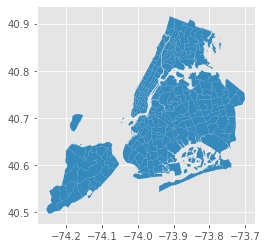

In [31]:
nyc.plot()

In [32]:
uber_data_location_total = uber_data[['Pickup_date','locationID']].groupby(['locationID']).size().reset_index(name = 'total_trips')
uber_data_location_total.head()

,locationID,total_trips
0,1,105
1,2,8
2,3,3684
3,4,89319
4,5,26


In [33]:
nyc['locationID'] = nyc['location_id'].astype('int64')
nyc_2 = nyc.merge(uber_data_location_total, on='locationID', how='left')
nyc_2.head()

,shape_area,objectid,shape_leng,location_id,zone,borough,geometry,locationID,total_trips
0,0.0007823067885,1,0.116357453189,1,Newark Airport,EWR,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...",1,105.0
1,0.00486634037837,2,0.43346966679,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",2,8.0
2,0.000314414156821,3,0.0843411059012,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...",3,3684.0
3,0.000111871946192,4,0.0435665270921,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...",4,89319.0
4,0.000497957489363,5,0.0921464898574,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...",5,26.0


Text(0.5, 1.0, 'Total Uber Pickups in NYC (Jan-Jun 2015)')

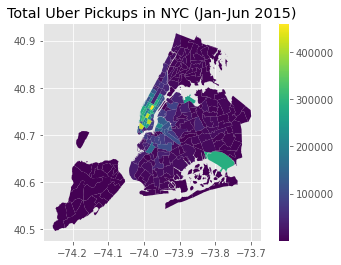

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

nyc_2.plot(column='total_trips', ax=ax, legend=True)
plt.title('Total Uber Pickups in NYC (Jan-Jun 2015)')

## PCA

### #1. WEEKDAYS

In [35]:
df_main.head()

,locationID,date_w_hr,trips,dayofweek,day,year,month,date,hour
109,1,2015-01-01 00:00:00,0,3,1,2015,1,2015-01-01,0
110,1,2015-01-01 01:00:00,0,3,1,2015,1,2015-01-01,1
111,1,2015-01-01 02:00:00,0,3,1,2015,1,2015-01-01,2
112,1,2015-01-01 03:00:00,0,3,1,2015,1,2015-01-01,3
2298,1,2015-01-01 04:00:00,0,3,1,2015,1,2015-01-01,4


In [36]:
# Filter to weekdays only; minor prep work
df_pre_pca_1 = df_main
df_pre_pca_1 = df_pre_pca_1.drop(columns=['date'])
df_pre_pca_1['hour'] = df_pre_pca_1['date_w_hr'].dt.hour
df_pre_pca_1['trips'] = df_pre_pca_1['trips'].replace(np.nan, 0)
# This is the only line that is different between the #1. Weekday and #2. Weekend Run
df_pre_pca_1 = df_pre_pca_1[(df_pre_pca_1['dayofweek'] >= 0) & (df_pre_pca_1['dayofweek'] < 5)] 
df_pre_pca_1.head()

,locationID,date_w_hr,trips,dayofweek,day,year,month,hour
109,1,2015-01-01 00:00:00,0,3,1,2015,1,0
110,1,2015-01-01 01:00:00,0,3,1,2015,1,1
111,1,2015-01-01 02:00:00,0,3,1,2015,1,2
112,1,2015-01-01 03:00:00,0,3,1,2015,1,3
2298,1,2015-01-01 04:00:00,0,3,1,2015,1,4


In [37]:
df_pre_pca_2 = df_pre_pca_1.groupby(['locationID','hour']).agg({'trips': 'mean'}).reset_index()
df_pre_pca_2.head()

,locationID,hour,trips
0,1,0,0.000000
1,1,1,0.007812
2,1,2,0.000000
3,1,3,0.000000
4,1,4,0.023438


In [38]:
# Consider splitting out weekends
df_pre_pca_3 = df_pre_pca_2.pivot(index='locationID', columns='hour', values='trips').fillna(value = 0)
df_pre_pca_3.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
locationID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.007812,0.000000,0.000000,0.023438,0.015625,0.093750,0.039062,0.031008,0.015504,...,0.046512,0.093023,0.038760,0.046512,0.015504,0.007752,0.007752,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812,0.000000,0.000000,...,0.007752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812
3,0.648438,0.398438,0.265625,0.468750,0.429688,0.414062,0.632812,1.546875,1.682171,1.317829,...,0.635659,0.627907,0.635659,0.782946,0.837209,1.062016,1.046512,0.953488,0.868217,0.843750
4,12.273438,7.187500,4.515625,3.359375,6.140625,9.984375,17.156250,28.093750,30.581395,38.124031,...,14.984496,14.062016,14.449612,16.503876,22.085271,27.713178,26.728682,24.302326,23.217054,22.601562
5,0.007812,0.000000,0.007812,0.000000,0.015625,0.007812,0.007812,0.000000,0.015504,0.000000,...,0.000000,0.015504,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015504,0.007812


In [39]:
df_pre_pca_3_t = df_pre_pca_3.T
df_pre_pca_3_t.shape

(24, 262)

Text(0, 0.5, '# trips')

<Figure size 432x288 with 0 Axes>

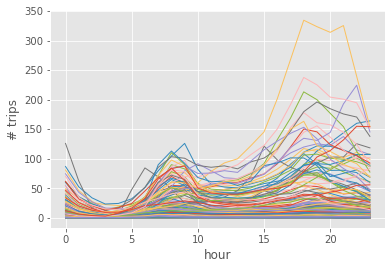

In [40]:
plt.figure(); df_pre_pca_3_t.plot(linewidth=1, legend=None); plt.ylabel('# trips')

In [41]:
df_hr_t = df_pre_pca_3

In [42]:
from sklearn.decomposition import PCA
from numpy.testing import assert_array_almost_equal

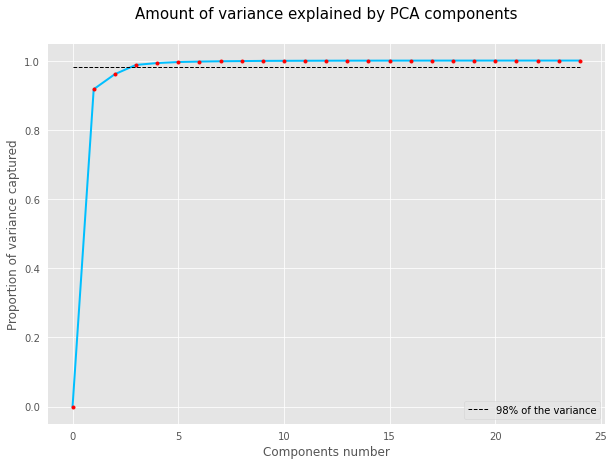

The first PC captures 91.71% of the variance
The first two PC capture 96.07% of the variance
The first three PC capture 98.75% of the variance
The first four PC capture 99.28% of the variance


In [43]:
n_components = len(df_hr_t.columns)

pca = PCA(n_components = n_components) #here you can do the plot with any number of n_components
pca.fit(df_hr_t)
list_variance = pca.explained_variance_ratio_

plt.figure(figsize = (10,7))
ax = plt.gca()
plt.plot(range(0, n_components+1), np.cumsum([0] + list(list_variance)),c='deepskyblue',linewidth = 2)
plt.plot(range(0, n_components+1), np.cumsum([0] + list(list_variance)),'.',c='r',markersize = 6)
plt.plot(range(0, n_components+1),[0.98 for i in range(0, n_components+1)],'--',c = 'black',
         linewidth = 1,label="98% of the variance")
plt.legend()
plt.xlabel('Components number',fontsize = 12)
plt.ylabel('Proportion of variance captured',fontsize = 12)
plt.title('Amount of variance explained by PCA components',fontsize = 15, y = 1.05)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
#plt.xticks(np.arange(0, 22, step=1))
ax.grid(True)
plt.show()
print("The first PC captures {:.2f}%".format(100*(np.cumsum([0] + list(list_variance))[1])),"of the variance")
print("The first two PC capture {:.2f}%".format(100*(np.cumsum([0] + list(list_variance))[2])),"of the variance")
print("The first three PC capture {:.2f}%".format(100*(np.cumsum([0] + list(list_variance))[3])),"of the variance")
print("The first four PC capture {:.2f}%".format(100*(np.cumsum([0] + list(list_variance))[4])),"of the variance")

In [44]:
number_c = 3
pca = PCA(number_c)
projected_data = pca.fit_transform(df_hr_t)
n_clusters = number_c

In [45]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = n_clusters)


membership = kmeans.fit_predict(projected_data) #Important this can be done projecting with any number of PCs 
Score = kmeans.score(projected_data)
centers = kmeans.cluster_centers_
centers_initial_base = pca.inverse_transform(centers)

clusters_dictionnary = {}
Clusters_names = ['Cluster ' + str(i) for i in range(1,n_clusters+1)]
for idx in range(len(Clusters_names)):
    clusters_dictionnary[Clusters_names[idx]] = centers_initial_base[idx,:]
    
    
clusters_data = pd.DataFrame(data = clusters_dictionnary)
# clusters_data['Variables'] = name_column
# clusters_data = clusters_data.set_index(PC_data['Variables'])
# del clusters_data['Variables']

In [46]:
# fit kmeans object to data
kmeans.fit(projected_data)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(projected_data)  ## based on centroids their colors below are cyan, red, black and blue 

[[146.58522121 -35.11581264   8.3826888 ]
 [376.07793853  18.69066636  -6.11058584]
 [-48.21668358   3.4927024   -0.71162635]]


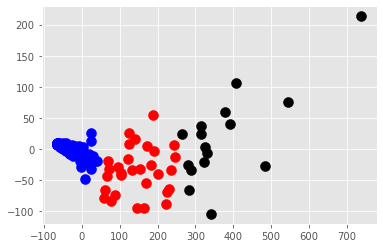

In [47]:
plt.scatter(projected_data[y_km ==0,0], projected_data[y_km == 0,1], s=100, c='red') ###Need other ways to 
                                                                                      ##visualize centroids
plt.scatter(projected_data[y_km ==1,0], projected_data[y_km == 1,1], s=100, c='black')
plt.scatter(projected_data[y_km ==2,0], projected_data[y_km == 2,1], s=100, c='blue')
plt.scatter(projected_data[y_km ==3,0], projected_data[y_km == 3,1], s=100, c='cyan')

In [48]:
df_hr_t.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
locationID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.007812,0.000000,0.000000,0.023438,0.015625,0.093750,0.039062,0.031008,0.015504,...,0.046512,0.093023,0.038760,0.046512,0.015504,0.007752,0.007752,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812,0.000000,0.000000,...,0.007752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812
3,0.648438,0.398438,0.265625,0.468750,0.429688,0.414062,0.632812,1.546875,1.682171,1.317829,...,0.635659,0.627907,0.635659,0.782946,0.837209,1.062016,1.046512,0.953488,0.868217,0.843750
4,12.273438,7.187500,4.515625,3.359375,6.140625,9.984375,17.156250,28.093750,30.581395,38.124031,...,14.984496,14.062016,14.449612,16.503876,22.085271,27.713178,26.728682,24.302326,23.217054,22.601562
5,0.007812,0.000000,0.007812,0.000000,0.015625,0.007812,0.007812,0.000000,0.015504,0.000000,...,0.000000,0.015504,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015504,0.007812


In [49]:
df_membership = pd.DataFrame({'cluster_number': membership})
df_membership['temp'] = range(0,len(df_membership.index))
df_membership.head()

,cluster_number,temp
0,2,0
1,2,1
2,2,2
3,2,3
4,2,4


In [50]:
number_members = [sum(membership==0), sum(membership==1), sum(membership==2), sum(membership==3)]
df = pd.DataFrame({'number_members':number_members})
df = df.sort_values(by='number_members', ascending=False)
#members_in_order = df.index
df=df.reset_index()
df['cluster_num_new'] = df.index
df['cluster_number'] = df['index']
df=df.drop(columns=['index'])
df

,number_members,cluster_num_new,cluster_number
0,216,0,2
1,30,1,0
2,16,2,1
3,0,3,3


In [51]:
df_membership_2 = df_membership.merge(df,on='cluster_number',how='left')
df_membership_2 = df_membership_2.drop(columns=['cluster_number','number_members'])
df_membership_2['cluster_number'] = df_membership_2['cluster_num_new']
df_membership_2 = df_membership_2.drop(columns=['cluster_num_new'])
df_membership_2.head()

,temp,cluster_number
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [52]:
df_hr_t['temp'] = range(0,len(df_hr_t.index))
# https://stackoverflow.com/questions/11976503/how-to-keep-index-when-using-pandas-merge
df_hr_t_membership = df_hr_t.merge(df_membership_2, on = 'temp', how = 'left').set_index(df_hr_t.index)
df_hr_t_membership = df_hr_t_membership.drop(columns=['temp'])
df_hr_t_membership.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,cluster_number
locationID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.007812,0.000000,0.000000,0.023438,0.015625,0.093750,0.039062,0.031008,0.015504,...,0.093023,0.038760,0.046512,0.015504,0.007752,0.007752,0.000000,0.000000,0.000000,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812,0
3,0.648438,0.398438,0.265625,0.468750,0.429688,0.414062,0.632812,1.546875,1.682171,1.317829,...,0.627907,0.635659,0.782946,0.837209,1.062016,1.046512,0.953488,0.868217,0.843750,0
4,12.273438,7.187500,4.515625,3.359375,6.140625,9.984375,17.156250,28.093750,30.581395,38.124031,...,14.062016,14.449612,16.503876,22.085271,27.713178,26.728682,24.302326,23.217054,22.601562,0
5,0.007812,0.000000,0.007812,0.000000,0.015625,0.007812,0.007812,0.000000,0.015504,0.000000,...,0.015504,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015504,0.007812,0


In [53]:
df_cluster_1 = df_hr_t_membership[df_hr_t_membership['cluster_number'] == 0].T
df_cluster_1 = df_cluster_1[:-1] # Drop cluster_number row
df_cluster_2 = df_hr_t_membership[df_hr_t_membership['cluster_number'] == 1].T
df_cluster_2 = df_cluster_2[:-1] # Drop cluster_number row
df_cluster_3 = df_hr_t_membership[df_hr_t_membership['cluster_number'] == 2].T
df_cluster_3 = df_cluster_3[:-1] # Drop cluster_number row
#df_cluster_4 = df_hr_t_membership[df_hr_t_membership['cluster_number'] == members_in_order[3]].T
#df_cluster_4 = df_cluster_4[:-1] # Drop cluster_number row

<AxesSubplot:title={'center':'Cluster 3'}>

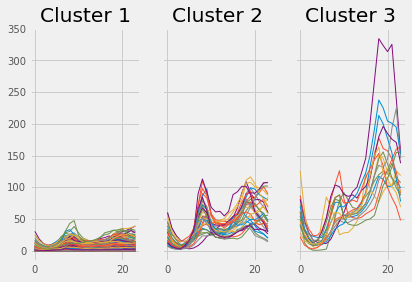

In [54]:
# Plot with the same y-axis
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
df_cluster_1.plot(ax=axes[0], legend=None, linewidth=1, title="Cluster 1", fontsize=10)
df_cluster_2.plot(ax=axes[1], legend=None, linewidth=1, title="Cluster 2", fontsize=10)
df_cluster_3.plot(ax=axes[2], legend=None, linewidth=1, title="Cluster 3", fontsize=10)
#df_cluster_4.plot(ax=axes[1,1], legend=None, linewidth=1, title="Cluster 4", fontsize=5)

Put back onto map

In [55]:
df_hr_t_membership.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,cluster_number
locationID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.007812,0.000000,0.000000,0.023438,0.015625,0.093750,0.039062,0.031008,0.015504,...,0.093023,0.038760,0.046512,0.015504,0.007752,0.007752,0.000000,0.000000,0.000000,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812,0
3,0.648438,0.398438,0.265625,0.468750,0.429688,0.414062,0.632812,1.546875,1.682171,1.317829,...,0.627907,0.635659,0.782946,0.837209,1.062016,1.046512,0.953488,0.868217,0.843750,0
4,12.273438,7.187500,4.515625,3.359375,6.140625,9.984375,17.156250,28.093750,30.581395,38.124031,...,14.062016,14.449612,16.503876,22.085271,27.713178,26.728682,24.302326,23.217054,22.601562,0
5,0.007812,0.000000,0.007812,0.000000,0.015625,0.007812,0.007812,0.000000,0.015504,0.000000,...,0.015504,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015504,0.007812,0


In [56]:
nyc_3 = nyc.merge(df_hr_t_membership, on='locationID', how='left')
nyc_3['cluster_number'] = nyc_3['cluster_number'] + 1
nyc_3.head()

,shape_area,objectid,shape_leng,location_id,zone,borough,geometry,locationID,0,1,...,15,16,17,18,19,20,21,22,23,cluster_number
0,0.0007823067885,1,0.116357453189,1,Newark Airport,EWR,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...",1,0.000000,0.007812,...,0.093023,0.038760,0.046512,0.015504,0.007752,0.007752,0.000000,0.000000,0.000000,1.0
1,0.00486634037837,2,0.43346966679,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",2,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812,1.0
2,0.000314414156821,3,0.0843411059012,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...",3,0.648438,0.398438,...,0.627907,0.635659,0.782946,0.837209,1.062016,1.046512,0.953488,0.868217,0.843750,1.0
3,0.000111871946192,4,0.0435665270921,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...",4,12.273438,7.187500,...,14.062016,14.449612,16.503876,22.085271,27.713178,26.728682,24.302326,23.217054,22.601562,1.0
4,0.000497957489363,5,0.0921464898574,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...",5,0.007812,0.000000,...,0.015504,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015504,0.007812,1.0


Note there are NA values for the unreachable islands in NYC.

<AxesSubplot:>

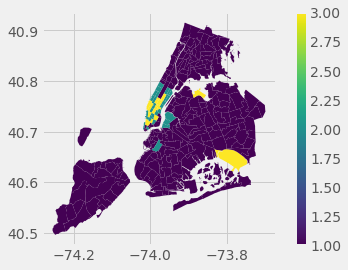

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

nyc_3.plot(column='cluster_number', ax=ax, legend=True)

### #2. WEEKENDS

In [58]:
df_main.head()

,locationID,date_w_hr,trips,dayofweek,day,year,month,date,hour
109,1,2015-01-01 00:00:00,0,3,1,2015,1,2015-01-01,0
110,1,2015-01-01 01:00:00,0,3,1,2015,1,2015-01-01,1
111,1,2015-01-01 02:00:00,0,3,1,2015,1,2015-01-01,2
112,1,2015-01-01 03:00:00,0,3,1,2015,1,2015-01-01,3
2298,1,2015-01-01 04:00:00,0,3,1,2015,1,2015-01-01,4


In [59]:
# Filter to weekdays only; minor prep work
df_pre_pca_1 = df_main
df_pre_pca_1 = df_pre_pca_1.drop(columns=['date'])
df_pre_pca_1['hour'] = df_pre_pca_1['date_w_hr'].dt.hour
df_pre_pca_1['trips'] = df_pre_pca_1['trips'].replace(np.nan, 0)
# This is the only line that is different between the #1. Weekday and #2. Weekend Run
df_pre_pca_1 = df_pre_pca_1[~((df_pre_pca_1['dayofweek'] >= 0) & (df_pre_pca_1['dayofweek'] < 5))] 
df_pre_pca_1.head()

,locationID,date_w_hr,trips,dayofweek,day,year,month,hour
123,1,2015-01-03 00:00:00,0,5,3,2015,1,0
2331,1,2015-01-03 01:00:00,0,5,3,2015,1,1
124,1,2015-01-03 02:00:00,0,5,3,2015,1,2
125,1,2015-01-03 03:00:00,0,5,3,2015,1,3
2332,1,2015-01-03 04:00:00,0,5,3,2015,1,4


In [60]:
df_pre_pca_2 = df_pre_pca_1.groupby(['locationID','hour']).agg({'trips': 'mean'}).reset_index()
df_pre_pca_2.head()

,locationID,hour,trips
0,1,0,0.0
1,1,1,0.0
2,1,2,0.0
3,1,3,0.0
4,1,4,0.0


In [61]:
# Consider splitting out weekends
df_pre_pca_3 = df_pre_pca_2.pivot(index='locationID', columns='hour', values='trips').fillna(value = 0)
df_pre_pca_3.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
locationID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.019231,0.019231,0.038462,0.019231,...,0.019231,0.038462,0.019231,0.076923,0.019231,0.000000,0.019231,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.403846,1.250000,1.098039,0.788462,0.711538,0.615385,0.326923,0.403846,1.038462,0.903846,...,1.076923,1.442308,1.153846,0.884615,1.115385,1.384615,1.192308,1.519231,1.711538,1.826923
4,43.173077,40.173077,27.176471,17.461538,12.384615,9.000000,8.211538,9.442308,11.884615,16.173077,...,27.173077,25.076923,27.423077,29.211538,36.326923,38.980769,37.211538,33.596154,34.711538,31.826923
5,0.057692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.019231,0.000000,0.000000,0.038462,0.000000,0.000000


In [62]:
df_pre_pca_3_t = df_pre_pca_3.T
df_pre_pca_3_t.shape

(24, 262)

Text(0, 0.5, '# trips')

<Figure size 432x288 with 0 Axes>

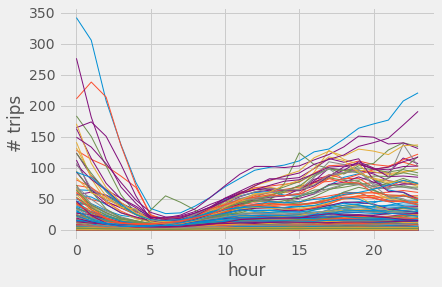

In [63]:
plt.figure(); df_pre_pca_3_t.plot(linewidth=1, legend=None); plt.ylabel('# trips')

In [64]:
df_hr_t = df_pre_pca_3

In [65]:
from sklearn.decomposition import PCA
from numpy.testing import assert_array_almost_equal

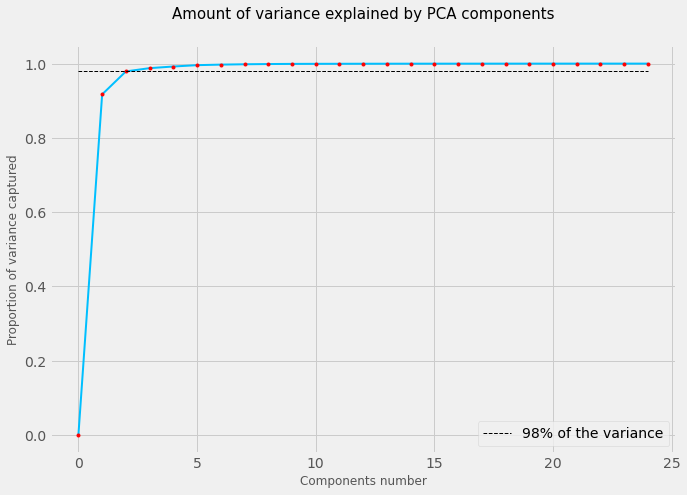

The first PC captures 91.71% of the variance
The first two PC capture 97.90% of the variance
The first three PC capture 98.78% of the variance
The first four PC capture 99.22% of the variance


In [66]:
n_components = len(df_hr_t.columns)

pca = PCA(n_components = n_components) #here you can do the plot with any number of n_components
pca.fit(df_hr_t)
list_variance = pca.explained_variance_ratio_

plt.figure(figsize = (10,7))
ax = plt.gca()
plt.plot(range(0, n_components+1), np.cumsum([0] + list(list_variance)),c='deepskyblue',linewidth = 2)
plt.plot(range(0, n_components+1), np.cumsum([0] + list(list_variance)),'.',c='r',markersize = 6)
plt.plot(range(0, n_components+1),[0.98 for i in range(0, n_components+1)],'--',c = 'black',
         linewidth = 1,label="98% of the variance")
plt.legend()
plt.xlabel('Components number',fontsize = 12)
plt.ylabel('Proportion of variance captured',fontsize = 12)
plt.title('Amount of variance explained by PCA components',fontsize = 15, y = 1.05)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
#plt.xticks(np.arange(0, 22, step=1))
ax.grid(True)
plt.show()
print("The first PC captures {:.2f}%".format(100*(np.cumsum([0] + list(list_variance))[1])),"of the variance")
print("The first two PC capture {:.2f}%".format(100*(np.cumsum([0] + list(list_variance))[2])),"of the variance")
print("The first three PC capture {:.2f}%".format(100*(np.cumsum([0] + list(list_variance))[3])),"of the variance")
print("The first four PC capture {:.2f}%".format(100*(np.cumsum([0] + list(list_variance))[4])),"of the variance")

In [67]:
number_c = 3
pca = PCA(number_c)
projected_data = pca.fit_transform(df_hr_t)
n_clusters = number_c

In [68]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = n_clusters)


membership = kmeans.fit_predict(projected_data) #Important this can be done projecting with any number of PCs 
Score = kmeans.score(projected_data)
centers = kmeans.cluster_centers_
centers_initial_base = pca.inverse_transform(centers)

clusters_dictionnary = {}
Clusters_names = ['Cluster ' + str(i) for i in range(1,n_clusters+1)]
for idx in range(len(Clusters_names)):
    clusters_dictionnary[Clusters_names[idx]] = centers_initial_base[idx,:]
    
    
clusters_data = pd.DataFrame(data = clusters_dictionnary)
# clusters_data['Variables'] = name_column
# clusters_data = clusters_data.set_index(PC_data['Variables'])
# del clusters_data['Variables']

In [69]:
# fit kmeans object to data
kmeans.fit(projected_data)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(projected_data)  ## based on centroids their colors below are cyan, red, black and blue 

[[408.09044552  78.20687249   0.86414653]
 [-47.91727519   3.4708313    0.50522511]
 [168.75597134 -37.09281412  -2.9716793 ]]


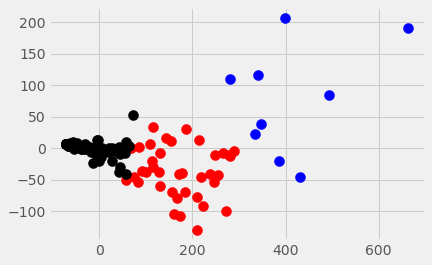

In [70]:
plt.scatter(projected_data[y_km ==0,0], projected_data[y_km == 0,1], s=100, c='red') ###Need other ways to 
                                                                                      ##visualize centroids
plt.scatter(projected_data[y_km ==1,0], projected_data[y_km == 1,1], s=100, c='black')
plt.scatter(projected_data[y_km ==2,0], projected_data[y_km == 2,1], s=100, c='blue')
plt.scatter(projected_data[y_km ==3,0], projected_data[y_km == 3,1], s=100, c='cyan')

In [71]:
df_hr_t.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
locationID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.019231,0.019231,0.038462,0.019231,...,0.019231,0.038462,0.019231,0.076923,0.019231,0.000000,0.019231,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.403846,1.250000,1.098039,0.788462,0.711538,0.615385,0.326923,0.403846,1.038462,0.903846,...,1.076923,1.442308,1.153846,0.884615,1.115385,1.384615,1.192308,1.519231,1.711538,1.826923
4,43.173077,40.173077,27.176471,17.461538,12.384615,9.000000,8.211538,9.442308,11.884615,16.173077,...,27.173077,25.076923,27.423077,29.211538,36.326923,38.980769,37.211538,33.596154,34.711538,31.826923
5,0.057692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.019231,0.000000,0.000000,0.038462,0.000000,0.000000


In [72]:
df_membership = pd.DataFrame({'cluster_number': membership})
df_membership['temp'] = range(0,len(df_membership.index))
df_membership.head()

,cluster_number,temp
0,0,0
1,0,1
2,0,2
3,1,3
4,0,4


In [73]:
number_members = [sum(membership==0), sum(membership==1), sum(membership==2), sum(membership==3)]
df = pd.DataFrame({'number_members':number_members})
df = df.sort_values(by='number_members', ascending=False)
#members_in_order = df.index
df=df.reset_index()
df['cluster_num_new'] = df.index
df['cluster_number'] = df['index']
df=df.drop(columns=['index'])
df

,number_members,cluster_num_new,cluster_number
0,212,0,0
1,41,1,1
2,9,2,2
3,0,3,3


In [74]:
df_membership_2 = df_membership.merge(df,on='cluster_number',how='left')
df_membership_2 = df_membership_2.drop(columns=['cluster_number','number_members'])
df_membership_2['cluster_number'] = df_membership_2['cluster_num_new']
df_membership_2 = df_membership_2.drop(columns=['cluster_num_new'])
df_membership_2.head()

,temp,cluster_number
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0


In [75]:
df_hr_t['temp'] = range(0,len(df_hr_t.index))
# https://stackoverflow.com/questions/11976503/how-to-keep-index-when-using-pandas-merge
df_hr_t_membership = df_hr_t.merge(df_membership_2, on = 'temp', how = 'left').set_index(df_hr_t.index)
df_hr_t_membership = df_hr_t_membership.drop(columns=['temp'])
df_hr_t_membership.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,cluster_number
locationID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.019231,0.019231,0.038462,0.019231,...,0.038462,0.019231,0.076923,0.019231,0.000000,0.019231,0.000000,0.000000,0.000000,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,1.403846,1.250000,1.098039,0.788462,0.711538,0.615385,0.326923,0.403846,1.038462,0.903846,...,1.442308,1.153846,0.884615,1.115385,1.384615,1.192308,1.519231,1.711538,1.826923,0
4,43.173077,40.173077,27.176471,17.461538,12.384615,9.000000,8.211538,9.442308,11.884615,16.173077,...,25.076923,27.423077,29.211538,36.326923,38.980769,37.211538,33.596154,34.711538,31.826923,1
5,0.057692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.019231,0.000000,0.000000,0.038462,0.000000,0.000000,0


In [76]:
df_cluster_1 = df_hr_t_membership[df_hr_t_membership['cluster_number'] == 0].T
df_cluster_1 = df_cluster_1[:-1] # Drop cluster_number row
df_cluster_2 = df_hr_t_membership[df_hr_t_membership['cluster_number'] == 1].T
df_cluster_2 = df_cluster_2[:-1] # Drop cluster_number row
df_cluster_3 = df_hr_t_membership[df_hr_t_membership['cluster_number'] == 2].T
df_cluster_3 = df_cluster_3[:-1] # Drop cluster_number row
#df_cluster_4 = df_hr_t_membership[df_hr_t_membership['cluster_number'] == members_in_order[3]].T
#df_cluster_4 = df_cluster_4[:-1] # Drop cluster_number row

<AxesSubplot:title={'center':'Cluster 3'}>

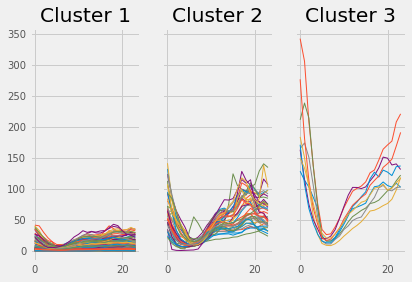

In [77]:
# Plot with the same y-axis
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
df_cluster_1.plot(ax=axes[0], legend=None, linewidth=1, title="Cluster 1", fontsize=10)
df_cluster_2.plot(ax=axes[1], legend=None, linewidth=1, title="Cluster 2", fontsize=10)
df_cluster_3.plot(ax=axes[2], legend=None, linewidth=1, title="Cluster 3", fontsize=10)
#df_cluster_4.plot(ax=axes[1,1], legend=None, linewidth=1, title="Cluster 4", fontsize=5)

Put back onto map

In [78]:
df_hr_t_membership.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,cluster_number
locationID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.019231,0.019231,0.038462,0.019231,...,0.038462,0.019231,0.076923,0.019231,0.000000,0.019231,0.000000,0.000000,0.000000,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,1.403846,1.250000,1.098039,0.788462,0.711538,0.615385,0.326923,0.403846,1.038462,0.903846,...,1.442308,1.153846,0.884615,1.115385,1.384615,1.192308,1.519231,1.711538,1.826923,0
4,43.173077,40.173077,27.176471,17.461538,12.384615,9.000000,8.211538,9.442308,11.884615,16.173077,...,25.076923,27.423077,29.211538,36.326923,38.980769,37.211538,33.596154,34.711538,31.826923,1
5,0.057692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.019231,0.000000,0.000000,0.038462,0.000000,0.000000,0


In [79]:
nyc_3 = nyc.merge(df_hr_t_membership, on='locationID', how='left')
nyc_3['cluster_number'] = nyc_3['cluster_number'] + 1
nyc_3.head()

,shape_area,objectid,shape_leng,location_id,zone,borough,geometry,locationID,0,1,...,15,16,17,18,19,20,21,22,23,cluster_number
0,0.0007823067885,1,0.116357453189,1,Newark Airport,EWR,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...",1,0.000000,0.000000,...,0.038462,0.019231,0.076923,0.019231,0.000000,0.019231,0.000000,0.000000,0.000000,1.0
1,0.00486634037837,2,0.43346966679,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",2,0.000000,0.000000,...,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2,0.000314414156821,3,0.0843411059012,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...",3,1.403846,1.250000,...,1.442308,1.153846,0.884615,1.115385,1.384615,1.192308,1.519231,1.711538,1.826923,1.0
3,0.000111871946192,4,0.0435665270921,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...",4,43.173077,40.173077,...,25.076923,27.423077,29.211538,36.326923,38.980769,37.211538,33.596154,34.711538,31.826923,2.0
4,0.000497957489363,5,0.0921464898574,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...",5,0.057692,0.000000,...,0.000000,0.000000,0.000000,0.019231,0.000000,0.000000,0.038462,0.000000,0.000000,1.0


Note there are NA values for the unreachable islands in NYC.

<AxesSubplot:>

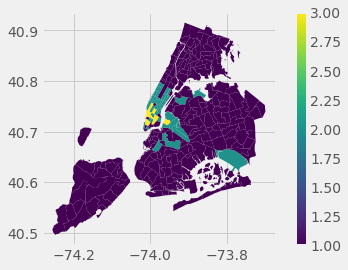

In [80]:
plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

nyc_3.plot(column='cluster_number', ax=ax, legend=True)

## MODELS

### MODEL 1: NO EVENT INFORMATION

In [81]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from scipy.stats import sem
import statsmodels.api as sm

In [82]:
X = df_main_3[['trips_last_wk', 'T_DD', 'PRCP']]
y = df_main_3['trips']

In [83]:
X.head()

,trips_last_wk,T_DD,PRCP
168,0.0,51,0.0
169,0.0,51,0.0
170,0.0,51,0.0
171,0.0,51,0.0
172,0.0,51,0.0


In [84]:
# https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
	# prepare the cross-validation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
	# create model
	model = linear_model.LinearRegression()
	# evaluate model
	scores = cross_val_score(model, X, y,  cv=cv, n_jobs=-1)
	return scores
 
# configurations to test
repeats = range(1,6)
results_model_1 = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X, y, r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results_model_1.append(scores)

>1 mean=0.8612 se=0.001
>2 mean=0.8612 se=0.001
>3 mean=0.8612 se=0.001
>4 mean=0.8612 se=0.001
>5 mean=0.8612 se=0.001


Text(0, 0.5, 'Mean $R^2$ Spread')

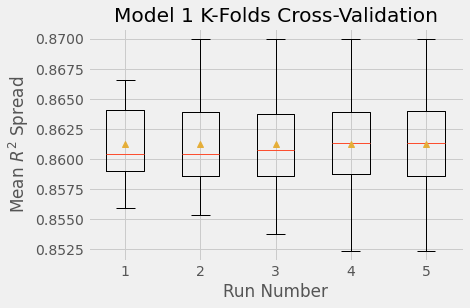

In [85]:
# plot the results
pyplot.boxplot(results_model_1, labels=[str(r) for r in repeats], showmeans=True)
pyplot.title('Model 1 K-Folds Cross-Validation')
pyplot.xlabel('Run Number')
pyplot.ylabel('Mean $R^2$ Spread')

In [86]:
X = df_main_3[['trips_last_wk', 'T_DD', 'PRCP']]
y = df_main_3['trips']

In [87]:
model = linear_model.LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)
print('r2', r2_score(y, y_pred))

Intercept: 
 0.6078512435155563
Coefficients: 
 [0.94422754 0.0091078  1.94248571]
r2 0.8612433863105031


### MODEL 2: MODEL 1 + EVENT ATTENDANCE

#### What about the number of trips on days with events?
##### We see that our model appears to underestimate the number of trips on days with events

Let's pull a couple event days and see how the prediction compares to the actual number of trips.

In [88]:
#Ex 1: Nets @ 3:30pm
df_main_3['trips_pred'] = y_pred
df_test_1 = df_main_3.loc[(df_main_3['locationID'] == 181)]
df_test_1 = df_test_1.loc[(df_test_1['date_w_hr'] > '2015-03-29 15:30:00') &  (df_test_1['date_w_hr'] < '2015-03-29 18:30:00')]
df_test_1

,locationID,date_w_hr,trips,dayofweek,day,year,month,date,hour,PRCP,TAVG,trips_last_wk,T_DD,trips_pred
773546,181,2015-03-29 16:00:00,41,6,29,2015,3,2015-03-29,16,0.0,34,52.0,31,49.990025
773547,181,2015-03-29 17:00:00,58,6,29,2015,3,2015-03-29,17,0.0,34,51.0,31,49.045797
773548,181,2015-03-29 18:00:00,53,6,29,2015,3,2015-03-29,18,0.0,34,43.0,31,41.491977


In [89]:
print('Ex 1: Nets 3/29 @ 3:30pm')
print(str(round(df_test_1.trips.sum() / df_test_1.trips_pred.sum(),3)), ' - sum of trips / sum of Model 1 predicted trips')

Ex 1: Nets 3/29 @ 3:30pm
1.082  - sum of trips / sum of Model 1 predicted trips


In [90]:
#Ex 2: Ed Sheeran @ 7:30pm
df_test_2 = df_main_3.loc[(df_main_3['locationID'] == 181)]
df_test_2 = df_test_2.loc[(df_test_2['date_w_hr'] > '2015-05-31 19:30:00') &  (df_test_2['date_w_hr'] < '2015-05-31 22:30:00')]
df_test_2

,locationID,date_w_hr,trips,dayofweek,day,year,month,date,hour,PRCP,TAVG,trips_last_wk,T_DD,trips_pred
775062,181,2015-05-31 20:00:00,72,6,31,2015,5,2015-05-31,20,0.02,69,66.0,4,63.002150
775063,181,2015-05-31 21:00:00,69,6,31,2015,5,2015-05-31,21,0.02,69,63.0,4,60.169467
775064,181,2015-05-31 22:00:00,105,6,31,2015,5,2015-05-31,22,0.02,69,70.0,4,66.779060


In [91]:
print('Ex 2: Ed Sheeran 5/31 @ 7:30pm')
print(str(round(df_test_2.trips.sum() / df_test_2.trips_pred.sum(),3)), ' - sum of trips / sum of Model 1 predicted trips')

Ex 2: Ed Sheeran 5/31 @ 7:30pm
1.295  - sum of trips / sum of Model 1 predicted trips


As compared to the average of the quotient of trips/trips_pred, it is clear that Model 1 understimates trip requests when there are events.

In [92]:
print(round(df_main_3.trips.sum()/df_main_3.trips_pred.sum(),3), ' - sum of all trips / sum of all Model 1 predicted trips')

1.0  - sum of all trips / sum of all Model 1 predicted trips


### Read in and prep events information

In [93]:
DATA_FILE = 'input/events_schedule.csv'
event_data = pd.read_csv(DATA_FILE)
event_data.head()

,event_name,venue,date,start_time,end_time,attendance
0,Chris Brown,Barclays,2/16/2015,19:30,21:30,12271
1,Neil Diamond,Barclays,3/26/2015,20:00,22:00,11920
2,Stevie Wonder,Barclays,4/12/2015,20:00,22:00,14159
3,The Who,Barclays,5/26/2015,20:00,22:00,11800
4,Ed Sheeran,Barclays,5/31/2015,19:30,21:30,14341


In [94]:
print("There are " + str(len(event_data.index)) + " events")

There are 108 events


In [95]:
event_data['date_start'] = event_data['date'] + ' ' + event_data['start_time']
# We will take any times up an hour after the expected end of the event
event_data['date_end'] = event_data['date'] + ' ' + event_data['end_time']
event_data['date_start'] = pd.to_datetime(event_data['date_start'], format="%m/%d/%Y %H:%M")
event_data['date_end'] = pd.to_datetime(event_data['date_end'], format="%m/%d/%Y %H:%M")
event_data.head()

,event_name,venue,date,start_time,end_time,attendance,date_start,date_end
0,Chris Brown,Barclays,2/16/2015,19:30,21:30,12271,2015-02-16 19:30:00,2015-02-16 21:30:00
1,Neil Diamond,Barclays,3/26/2015,20:00,22:00,11920,2015-03-26 20:00:00,2015-03-26 22:00:00
2,Stevie Wonder,Barclays,4/12/2015,20:00,22:00,14159,2015-04-12 20:00:00,2015-04-12 22:00:00
3,The Who,Barclays,5/26/2015,20:00,22:00,11800,2015-05-26 20:00:00,2015-05-26 22:00:00
4,Ed Sheeran,Barclays,5/31/2015,19:30,21:30,14341,2015-05-31 19:30:00,2015-05-31 21:30:00


In [96]:
def round_down_hr(x):
    return(x.replace(minute=0, second=0))

In [97]:
# Round hours to permit join
# https://stackoverflow.com/questions/49561989/pandas-rounding-to-nearest-hour
df_event_rd_1 = event_data
df_event_rd_1['date_start_rd'] = df_event_rd_1['date_start'].apply(lambda x: round_down_hr(x))

# Note that this column will capture all times within the hour once the join happens
# For example: An event ending at 21:30 will include all pickups from 21:00 -> 22:00pm
df_event_rd_1['date_end_rd'] = df_event_rd_1['date_end'].apply(lambda x: round_down_hr(x))
df_event_rd_1.head()

,event_name,venue,date,start_time,end_time,attendance,date_start,date_end,date_start_rd,date_end_rd
0,Chris Brown,Barclays,2/16/2015,19:30,21:30,12271,2015-02-16 19:30:00,2015-02-16 21:30:00,2015-02-16 19:00:00,2015-02-16 21:00:00
1,Neil Diamond,Barclays,3/26/2015,20:00,22:00,11920,2015-03-26 20:00:00,2015-03-26 22:00:00,2015-03-26 20:00:00,2015-03-26 22:00:00
2,Stevie Wonder,Barclays,4/12/2015,20:00,22:00,14159,2015-04-12 20:00:00,2015-04-12 22:00:00,2015-04-12 20:00:00,2015-04-12 22:00:00
3,The Who,Barclays,5/26/2015,20:00,22:00,11800,2015-05-26 20:00:00,2015-05-26 22:00:00,2015-05-26 20:00:00,2015-05-26 22:00:00
4,Ed Sheeran,Barclays,5/31/2015,19:30,21:30,14341,2015-05-31 19:30:00,2015-05-31 21:30:00,2015-05-31 19:00:00,2015-05-31 21:00:00


In [98]:
df_event_rd_2 = df_event_rd_1.drop(columns=['start_time', 'end_time','date_start','date_end'])
df_event_rd_2.head()

,event_name,venue,date,attendance,date_start_rd,date_end_rd
0,Chris Brown,Barclays,2/16/2015,12271,2015-02-16 19:00:00,2015-02-16 21:00:00
1,Neil Diamond,Barclays,3/26/2015,11920,2015-03-26 20:00:00,2015-03-26 22:00:00
2,Stevie Wonder,Barclays,4/12/2015,14159,2015-04-12 20:00:00,2015-04-12 22:00:00
3,The Who,Barclays,5/26/2015,11800,2015-05-26 20:00:00,2015-05-26 22:00:00
4,Ed Sheeran,Barclays,5/31/2015,14341,2015-05-31 19:00:00,2015-05-31 21:00:00


In [99]:
# Create a row for each hour within the time range of interest
# This will create for us our column we will join on with the main dataframe
# https://stackoverflow.com/questions/57525566/expand-rows-by-date-range-having-start-and-end-in-pandas
df_event_rd_3 = df_event_rd_2
df_event_rd_3['hour'] = df_event_rd_3.apply(lambda row: pd.date_range(row['date_start_rd'], row['date_end_rd'], freq='H'), axis=1)
df_event_rd_3 = df_event_rd_3.explode('hour').reset_index() \
        .drop(columns=['date_start_rd', 'date_end_rd']) \
        .rename(columns={'hour': 'date_w_hr'}) \
        .drop(columns=['index', 'date'])
df_event_rd_3.head()

,event_name,venue,attendance,date_w_hr
0,Chris Brown,Barclays,12271,2015-02-16 19:00:00
1,Chris Brown,Barclays,12271,2015-02-16 20:00:00
2,Chris Brown,Barclays,12271,2015-02-16 21:00:00
3,Neil Diamond,Barclays,11920,2015-03-26 20:00:00
4,Neil Diamond,Barclays,11920,2015-03-26 21:00:00


In [100]:
# Appropriate taxi zone found here: 
d = {'venue': ['Barclays', 'Yankee Stadium', 'Citi Field'], 'locationID': [181, 247, 93]}
df_event_center_info = pd.DataFrame(d)
df_event_center_info

,venue,locationID
0,Barclays,181
1,Yankee Stadium,247
2,Citi Field,93


In [101]:
df_event_info = df_event_rd_3.merge(df_event_center_info, on='venue', how='left')
df_event_info.head()

,event_name,venue,attendance,date_w_hr,locationID
0,Chris Brown,Barclays,12271,2015-02-16 19:00:00,181
1,Chris Brown,Barclays,12271,2015-02-16 20:00:00,181
2,Chris Brown,Barclays,12271,2015-02-16 21:00:00,181
3,Neil Diamond,Barclays,11920,2015-03-26 20:00:00,181
4,Neil Diamond,Barclays,11920,2015-03-26 21:00:00,181


### Join in events information and re-perform regression

In [102]:
df_main_3.head()

,locationID,date_w_hr,trips,dayofweek,day,year,month,date,hour,PRCP,TAVG,trips_last_wk,T_DD,trips_pred
168,1,2015-01-08 00:00:00,0,3,8,2015,1,2015-01-08,0,0.0,14,0.0,51,1.072349
169,1,2015-01-08 01:00:00,0,3,8,2015,1,2015-01-08,1,0.0,14,0.0,51,1.072349
170,1,2015-01-08 02:00:00,0,3,8,2015,1,2015-01-08,2,0.0,14,0.0,51,1.072349
171,1,2015-01-08 03:00:00,0,3,8,2015,1,2015-01-08,3,0.0,14,0.0,51,1.072349
172,1,2015-01-08 04:00:00,0,3,8,2015,1,2015-01-08,4,0.0,14,0.0,51,1.072349


In [103]:
df_main_4 = df_main_3.merge(df_event_info, on=['locationID','date_w_hr'], how='left')
df_main_4['event_name'] = df_main_4['event_name'].replace(np.nan, "")
df_main_4['venue'] = df_main_4['venue'].replace(np.nan, "")
df_main_4['attendance'] = df_main_4['attendance'].replace(np.nan, 0)
df_main_4.head()

,locationID,date_w_hr,trips,dayofweek,day,year,month,date,hour,PRCP,TAVG,trips_last_wk,T_DD,trips_pred,event_name,venue,attendance
0,1,2015-01-08 00:00:00,0,3,8,2015,1,2015-01-08,0,0.0,14,0.0,51,1.072349,,,0.0
1,1,2015-01-08 01:00:00,0,3,8,2015,1,2015-01-08,1,0.0,14,0.0,51,1.072349,,,0.0
2,1,2015-01-08 02:00:00,0,3,8,2015,1,2015-01-08,2,0.0,14,0.0,51,1.072349,,,0.0
3,1,2015-01-08 03:00:00,0,3,8,2015,1,2015-01-08,3,0.0,14,0.0,51,1.072349,,,0.0
4,1,2015-01-08 04:00:00,0,3,8,2015,1,2015-01-08,4,0.0,14,0.0,51,1.072349,,,0.0


In [104]:
# Note: some values not brought over in join - possible there is not a row
df_main_4[df_main_4['attendance'] > 0].head()

,locationID,date_w_hr,trips,dayofweek,day,year,month,date,hour,PRCP,TAVG,trips_last_wk,T_DD,trips_pred,event_name,venue,attendance
385555,93,2015-04-13 13:00:00,2,0,13,2015,4,2015-04-13,13,0.00,51,0.0,14,0.735360,Mets play PHI,Citi Field,43947.0
385556,93,2015-04-13 14:00:00,3,0,13,2015,4,2015-04-13,14,0.00,51,0.0,14,0.735360,Mets play PHI,Citi Field,43947.0
385557,93,2015-04-13 15:00:00,10,0,13,2015,4,2015-04-13,15,0.00,51,0.0,14,0.735360,Mets play PHI,Citi Field,43947.0
385558,93,2015-04-13 16:00:00,33,0,13,2015,4,2015-04-13,16,0.00,51,1.0,14,1.679588,Mets play PHI,Citi Field,43947.0
385585,93,2015-04-14 19:00:00,0,1,14,2015,4,2015-04-14,19,0.04,56,0.0,9,0.767521,Mets play PHI,Citi Field,39489.0


The original model chronically underpredicts pickups on event days. The R-squared is significantly lower for our event days than our total data set - this in large part due to the relatively few data points that are considered "event," but nevertheless both of these facts point to events being a potentially important feature in forecasting Uber pickups.

In [105]:
Y_event = df_main_4[df_main_4['attendance'] > 0]['trips']
Y_pred_event = df_main_4[df_main_4['attendance'] > 0]['trips_pred']
sum_trip_events = sum(Y_event)
sum_trip_pred_events = sum(Y_pred_event)
print(str(round(sum_trip_events / sum_trip_pred_events, 3)) + " - Model 1 ratio of actual trips to predicted trips on event days")

1.489 - Model 1 ratio of actual trips to predicted trips on event days


In [106]:
print('Event r2', r2_score(Y_event, Y_pred_event))

Event r2 0.5503256129489418


In [107]:
print('Total r2', r2_score(df_main_3['trips'], df_main_3['trips_pred']))

Total r2 0.8612433863105031


Recreate model with event attendance as new feature

In [108]:
# https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
	# prepare the cross-validation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
	# create model
	model = linear_model.LinearRegression()
	# evaluate model
	scores = cross_val_score(model, X, y,  cv=cv, n_jobs=-1)
	return scores
 
# configurations to test
repeats = range(1,6)
results_model_2 = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X, y, r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results_model_2.append(scores)

>1 mean=0.8612 se=0.001
>2 mean=0.8612 se=0.001
>3 mean=0.8612 se=0.001
>4 mean=0.8612 se=0.001
>5 mean=0.8612 se=0.001


Text(0, 0.5, 'Mean $R^2$ Spread')

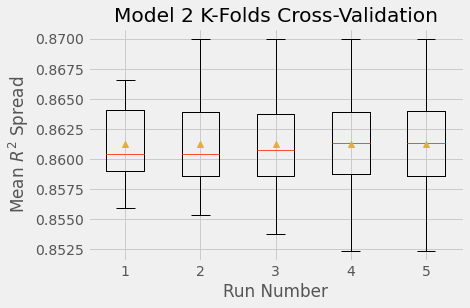

In [109]:
# plot the results
pyplot.boxplot(results_model_2, labels=[str(r) for r in repeats], showmeans=True)
pyplot.title('Model 2 K-Folds Cross-Validation')
pyplot.xlabel('Run Number')
pyplot.ylabel('Mean $R^2$ Spread')

In [110]:
X = df_main_4[['trips_last_wk', 'attendance', 'T_DD', 'PRCP']]
y = df_main_4['trips']

In [111]:
model = linear_model.LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)
print('r2', r2_score(y, y_pred))

Intercept: 
 0.6031109510656414
Coefficients: 
 [9.44233270e-01 2.37269766e-04 9.21771391e-03 1.94323989e+00]
r2 0.8612662292779192


In [112]:
print('Overall model performance has changed very little after introducing event attendance.')
print('This may be expected - event hour trips represent ', str(round(((sum_trip_events / sum(df_main_4['trips'])) * 100), 3)), '% of trips')

Overall model performance has changed very little after introducing event attendance.
This may be expected - event hour trips represent  0.063 % of trips


In [113]:
print(str(round(df_main_4.trips.sum()/df_main_4.trips_pred.sum(),3)), ' - sum of all trips / sum of Model 2 predicted trips')

1.0  - sum of all trips / sum of Model 2 predicted trips


In [114]:
Y_pred_w_event = model.predict(X)
df_main_5 = df_main_4
df_main_5['trips_pred_w_event'] = Y_pred_w_event
df_main_5.head()

,locationID,date_w_hr,trips,dayofweek,day,year,month,date,hour,PRCP,TAVG,trips_last_wk,T_DD,trips_pred,event_name,venue,attendance,trips_pred_w_event
0,1,2015-01-08 00:00:00,0,3,8,2015,1,2015-01-08,0,0.0,14,0.0,51,1.072349,,,0.0,1.073214
1,1,2015-01-08 01:00:00,0,3,8,2015,1,2015-01-08,1,0.0,14,0.0,51,1.072349,,,0.0,1.073214
2,1,2015-01-08 02:00:00,0,3,8,2015,1,2015-01-08,2,0.0,14,0.0,51,1.072349,,,0.0,1.073214
3,1,2015-01-08 03:00:00,0,3,8,2015,1,2015-01-08,3,0.0,14,0.0,51,1.072349,,,0.0,1.073214
4,1,2015-01-08 04:00:00,0,3,8,2015,1,2015-01-08,4,0.0,14,0.0,51,1.072349,,,0.0,1.073214


Even though overall model performance is about the same,
We now we see that our predictions for events are MUCH better.

In [115]:
Y_event = df_main_5[df_main_5['attendance'] > 0]['trips']
Y_pred_event = df_main_5[df_main_5['attendance'] > 0]['trips_pred_w_event']
sum_trip_events = sum(Y_event)
sum_trip_pred_events = sum(Y_pred_event)
print(round(sum_trip_events / sum_trip_pred_events, 3), " - Model 2 ratio of actual trips to predicted trips on event days")

1.041  - Model 2 ratio of actual trips to predicted trips on event days


In [116]:
print('Event r2', r2_score(Y_event, Y_pred_event))

Event r2 0.6382681433043635
